# Customer Segmentation using K-Means Clustering

<br><br>
The marketing team of a local supermarket is planning to launch a campaign for some new products to their customers. In order to ensure the efficiency of this campaign and target the right groups, they need to think about the different types of grocery customers that are shopping at the store. Some customers may buy from all the food departments, just varying amounts depending on how many in their households. Other customers may buy foods based on specific diets or preferences, meaning they shop or don't shop in certain product areas due to their lifestyles. 

This exercise can be seen as customer segmentation. In this Notebook we will discuss how K-Means Clustering will help our marketing team to segment their customers based on their shopping behaviour.

Let's import the required libraries for the analysis.

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

Customer transactions data have been collected by the supermarket team and imported into the following variables

In [2]:
transactions = pd.read_excel("data/grocery_database.xlsx", sheet_name = "transactions")
product_areas = pd.read_excel("data/grocery_database.xlsx", sheet_name = "product_areas")
transactions = pd.merge(transactions, product_areas, how = "inner", on = "product_area_id")

In [3]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14


In [4]:
transactions["product_area_name"].unique()

array(['Fruit', 'Vegetables', 'Dairy', 'Non-Food', 'Meat'], dtype=object)

Let's drop the Non-Food category since it will not give added value to the segmentation analysis. The transactions dataframe is now read as follows.

In [5]:
transactions.drop(transactions[transactions['product_area_name'] == "Non-Food"].index, inplace = True)

In [6]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14


Let's aggregate sales at customer level, i.e. group the customers by product area name and sum all the costs incurred for each customer per each product area name. The transaction summary per each product area of each customer reads as follows.

In [7]:
transaction_summary = transactions.groupby(["customer_id", "product_area_name"])["sales_cost"].sum()

In [8]:
transaction_summary

customer_id  product_area_name
1            Dairy                367.74
             Fruit                276.00
             Meat                 543.38
             Vegetables           167.12
2            Dairy                150.63
                                   ...  
869          Vegetables           168.85
870          Dairy                247.97
             Fruit                322.90
             Meat                 284.26
             Vegetables           203.80
Name: sales_cost, Length: 3156, dtype: float64

Create pivot table to place product areas as columns.

In [9]:
transaction_summary_pivot = transactions.pivot_table(index = "customer_id",
                                                    columns = "product_area_name", 
                                                    values = "sales_cost",
                                                    aggfunc = "sum",
                                                    fill_value = 0,
                                                    margins = True,
                                                    margins_name = "Total").rename_axis(None, axis = 1)

In [10]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32
...,...,...,...,...,...
867,129.84,176.73,180.49,88.83,575.89
868,225.59,358.89,343.26,189.24,1116.98
869,126.28,127.50,183.88,168.85,606.51


The pivot table above will not say much about the sales figure. Let's turn the above table to show percentage of sales. The customer sale percentage figure per each product area is read as follows.

In [11]:
transaction_summary_pivot = transaction_summary_pivot.div(transaction_summary_pivot["Total"], axis = 0)

In [12]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


Let's drop column as well as the index row "Total" since it doesn't give any added value.

In [13]:
data_for_clustering =   transaction_summary_pivot.drop(index='Total', columns='Total')

In [14]:
data_for_clustering

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218
...,...,...,...,...
866,0.206887,0.188798,0.457852,0.146462
867,0.225460,0.306882,0.313411,0.154248
868,0.201964,0.321304,0.307311,0.169421


Check the missing values of the data

In [15]:
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

The data is ready to be analysed. 

Let's normalize the data to make the computation more efficient.

In [16]:
scale_norm = MinMaxScaler()
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

In [17]:
data_for_clustering_scaled

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065
...,...,...,...,...
865,0.235455,0.232401,0.493357,0.195430
866,0.256592,0.377756,0.337714,0.205820
867,0.229852,0.395509,0.331142,0.226066
868,0.236958,0.258769,0.326687,0.371476


K-means clustering is a method to partition data points into distinct groups/clusters based on their similarity with each other. The number of distinct clusters is determined by the value *k*. Similarity is measured by the mean dimension values of its cluster.

To ensure an optimal number of *k*, we measure the sum of squared euclidean distances that data points lie from their closest centroid, called *Within Cluster Sum of Squares* or *WCSS*. WCSS can help us understand the point whether adding more centroids will provides little benefit or not. This is also called "Elbow method". It is a method to find a point where diminishing returns are no longer worth the additional cost.

Let's now use WCSS to find optimal value for k.

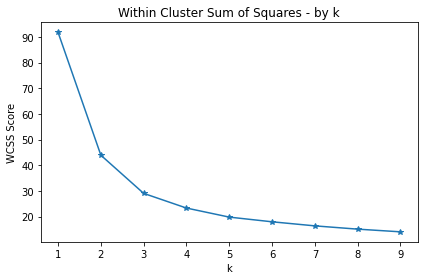

In [18]:
k_values = list(range(1,10))
wcss_list = []

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)
    
    
plt.plot(k_values, wcss_list, '-*')    
plt.title("Within Cluster Sum of Squares - by k")
plt.xlabel("k")
plt.ylabel("WCSS Score")
plt.tight_layout()
plt.show()

From the plot above we see that as *k* reach 3, the incremental decreasing of WCSS becomes smaller hence not worth the additional cost of increasing *k*. Therefore, we choose *k* = 3.

Now let's instantiate KMeans model with the choice *k* = 3.

In [19]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

The resulting clusters are checked and added to the original data.

In [20]:
data_for_clustering["cluster"] = kmeans.labels_

# check cluster sizes

data_for_clustering["cluster"].value_counts()

1    640
0    127
2    103
Name: cluster, dtype: int64

In [21]:
data_for_clustering

,Dairy,Fruit,Meat,Vegetables,cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1
2,0.246200,0.197656,0.394250,0.161894,1
3,0.142496,0.232527,0.527821,0.097156,1
4,0.341088,0.244770,0.272134,0.142008,1
5,0.212754,0.249691,0.430338,0.107218,1
...,...,...,...,...,...
866,0.206887,0.188798,0.457852,0.146462,1
867,0.225460,0.306882,0.313411,0.154248,1
868,0.201964,0.321304,0.307311,0.169421,1


Let's check the profile of the resulting Clusters by investigating the mean value of each product area.

In [22]:
cluster_summary = data_for_clustering.groupby("cluster")[["Dairy", "Fruit", "Meat", "Vegetables"]].mean().reset_index()

In [23]:
cluster_summary

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.363948,0.394152,0.029210,0.212690
1,1,0.220878,0.264528,0.376627,0.137966
2,2,0.002382,0.637796,0.003696,0.356126


From the table above we observe the following:

1. Customers belong to Cluster 0 have low mean percentage for Meat product area, while the other product areas are of similar percentage. We may assume that this cluster represents vegetarian customers
2. Customers belong to Cluster 1 have more or less similar percentage of all product areas. We may see this as general customer cluster which represents neither vegetarians or vegans
3. Customers belong to Cluster 2 have very low mean percentage for meat and dairy product. This cluster would probably represents vegan customers 


## Conclusions

1. Customer segmentation analysis has been provided for a given customer dataset. Here, K-Means Clustering method from Scikit-learn library of Python has been used in the analysis. <br> <br>
2. Elbow method has been utilized to find the optimal number of clusters for the analysis. Here, the sum of squared euclidean distances that data points lie from their closest centroid are measured. <br> <br>
3. From the analysis we conclude that, based on the given data, the customers can be segmented into 3 clusters; Cluster 0 represents the vegetarian customers; Cluster 1 represents the general customers; Cluster 2 represents the vegan customers. <br> <br>
4. Based on the above results, the marketing team can now send the customized campaign of the new products per each customer cluster.